Median:  67.0
[32 36]


c:\python\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\python\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'pca = PCA()\npes = pca.fit_transform(df_train[col])\n\ndf_pes = pd.DataFrame(pes)\ndf_pes.columns = ["PC_"+str(i) for i in range(len(pes))]\ndf_pes[\'Subject\'], df_pes[\'Age\'], df_pes[\'Age_bins\'] = df_train[\'Subject\'], df_train[\'Age\'], df_train[\'Age_bins\']\ncol1 = [x for x in df_pes.columns if \'PC_\' in x]\ncol2 = []\n# [3] considers those principal components that are significantly correlated with age\nfor i in col1:\n    check = scipy.stats.pearsonr(df_pes[i], df_pes[\'Age\'])[1]\n    if check < 0.1:\n        col2.append(i)\ndf_train = df_pes\nc = col2\n'

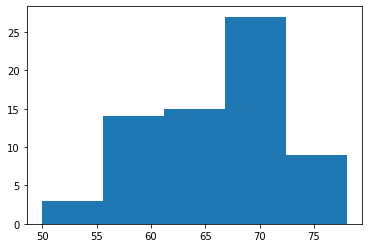

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import scipy.stats
# pip install https://github.com/JamesRitchie/scikit-rvm/archive/master.zip
from skrvm import RVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from julearn import run_cross_validation
from julearn.utils import configure_logging
from nilearn.datasets import fetch_atlas_schaefer_2018, fetch_atlas_aal
from nilearn import plotting
from nilearn import image
from sklearn.feature_selection import mutual_info_classif, SelectPercentile
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, confusion_matrix, balanced_accuracy_score
sys.path.append("../lib")
from create_splits import stratified_splits

df = pd.read_csv('../data/test_train_MRI.csv', index_col=0)

df_train = df[df['train'] == "T"]
# round to no decimal place
df_train['Age'] = np.around(df_train['Age'].astype(int))
med = np.median(df_train['Age'])
print("Median: ", med)
df_train['Age_bin'] = [0 if x< med else 1 for x in df_train['Age']]
print(np.bincount(df_train['Age_bin']))
df_train = df_train.reset_index(drop=True)
col = [x for x in df_train.columns if ('_L' in x) or ('_R' in x) or ('Vermis' in x)]
plt.hist(df_train['Age'], bins=5)
c = col
# uncomment for PCA
# [1] creates principal components, 
# [2] calculates cross products of brain scan and principal components,
"""pca = PCA()
pes = pca.fit_transform(df_train[col])

df_pes = pd.DataFrame(pes)
df_pes.columns = ["PC_"+str(i) for i in range(len(pes))]
df_pes['Subject'], df_pes['Age'], df_pes['Age_bins'] = df_train['Subject'], df_train['Age'], df_train['Age_bins']
col1 = [x for x in df_pes.columns if 'PC_' in x]
col2 = []
# [3] considers those principal components that are significantly correlated with age
for i in col1:
    check = scipy.stats.pearsonr(df_pes[i], df_pes['Age'])[1]
    if check < 0.1:
        col2.append(i)
df_train = df_pes
c = col2
"""


In [163]:
rand_seed = 42
num_bins = 5
rvm = RVC()
svm = SVC()
rfc = RandomForestClassifier()
gpc = GaussianProcessClassifier()
models = [rvm, svm, rfc, gpc]
model_names = ['rvm', 'svm', 'rfc', 'gpc']
splits = 5

model_results = []
scores_results = []
res = {}
age_pred = {}

res['model'] = []
res['iter'] = []
res['pred'] = []
res['real'] = []
res['ind'] = []
# res = pd.Series(index=df_train.index)
for i, model in enumerate(models):
    cv = StratifiedKFold(n_splits=splits).split(df_train[c],
                                                df_train['Age_bins'])
    cv = list(cv)
    scores, final_model = run_cross_validation(X=c, y='Age_bin',
                                         # preprocess_X='scaler_robust',
                                         # problem_type='classification',
                                         data=df_train,
                                         model=model, cv=cv,
                                         return_estimator='all',
                                         seed=rand_seed,
                                         scoring=['balanced_accuracy'])
    model_results.append(final_model)
    scores_results.append(scores)
    for iter in range(splits):
        pred = scores.estimator[iter].predict(df_train.iloc[cv[iter][1]][c])
        real = df_train.iloc[cv[iter][1]]['Age_bin'].tolist()
        res['pred'].append(pred)
        res['real'].append(real)
        res['iter'].append(iter)
        res['model'].append(str(model))
        res['ind'].append(cv[iter][1])

    df_res = pd.DataFrame(res)

for m in models:
    ba = []
    y_true = df_res['real'][df_res['model'] == str(m)].tolist()
    y_pred = df_res['pred'][df_res['model'] == str(m)].tolist()
    for s in range(splits):
        ba.append(np.round(balanced_accuracy_score(y_true[s], y_pred[s]),2))
        print("Balanced accuracy {} fold {}: {}".format(model_names[models.index(m)], s, ba[s]))
    print("AVERAGE Balanced accuracy {}: {}".format(model_names[models.index(m)], np.round(np.mean(ba),2)))

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Balanced accuracy rvm fold 0: 0.47
Balanced accuracy rvm fold 1: 0.75
Balanced accuracy rvm fold 2: 0.42
Balanced accuracy rvm fold 3: 0.69
Balanced accuracy rvm fold 4: 0.46
AVERAGE Balanced accuracy rvm: 0.56
Balanced accuracy svm fold 0: 0.56
Balanced accuracy svm fold 1: 0.5
Balanced accuracy svm fold 2: 0.59
Balanced accuracy svm fold 3: 0.52
Balanced accuracy svm fold 4: 0.39
AVERAGE Balanced accuracy svm: 0.51
Balanced accuracy rfc fold 0: 0.47
Balanced accuracy rfc fold 1: 0.42
Balanced accuracy rfc fold 2: 0.42
Balanced accuracy rfc fold 3: 0.46
Balanced accuracy rfc fold 4: 0.6
AVERAGE Balanced accuracy rfc: 0.47
Balanced accuracy gpc fold 0: 0.56
Balanced accuracy gpc fold 1: 0.5
Balanced accuracy gpc fold 2: 0.43
Balanced accuracy gpc fold 3: 0.52
Balanced accuracy gpc fold 4: 0.51
AVERAGE Balanced accuracy gpc: 0.5


### Plot Relevant Regions

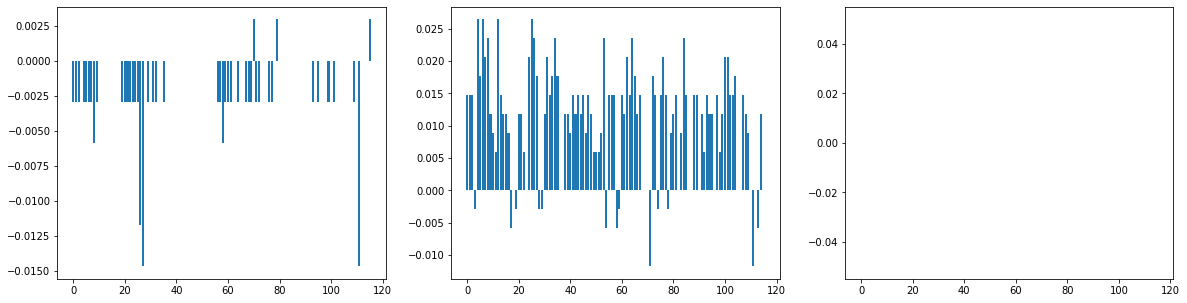

In [126]:
# permutation importance
rvm.fit(df_train[c], df_train['Age_bin'])
rvm_feature_importance = permutation_importance(model_results[0]['rvc'],df_train[c],
                                                df_train['Age_bin'], scoring="balanced_accuracy")
svm.fit(df_train[c], df_train['Age_bin'])
svm_feature_importance = permutation_importance(model_results[1]['svc'],df_train[c],
                                                df_train['Age_bin'], scoring="balanced_accuracy")
rfc.fit(df_train[c], df_train['Age_bin'])
rfc_feature_importance = permutation_importance(model_results[2]['randomforestclassifier'],df_train[c],
                                                df_train['Age_bin'], scoring="balanced_accuracy")
fig,ax = plt.subplots(1,3, figsize = (20,5))
ax[0].bar(range(df_train[c].shape[1]),rvm_feature_importance.importances_mean)
ax[1].bar(range(df_train[c].shape[1]),svm_feature_importance.importances_mean)
ax[2].bar(range(df_train[c].shape[1]),rfc_feature_importance.importances_mean)
plt.show()

### Plot Relevant Regions in Glass Brain

In [129]:
atlas_file = fetch_atlas_aal()
atlas = image.load_img(atlas_file.maps)
atlas_matrix = image.get_data(atlas)


Dataset created in C:\Users\doeringe/nilearn_data\aal_SPM12



 ...done. (1 seconds, 0 min)
Extracting data from C:\Users\doeringe/nilearn_data\aal_SPM12\3d9806fc1addf495fd688a71eed4b1b7\aal_for_SPM12.tar.gz..... done.


In [132]:
# create statistical map where each voxel value coresponds to permutation importance
rvm_imp = rvm_feature_importance.importances_mean
atlas_matrix_stat = atlas_matrix.copy()

for x in range(117):
    if x == 0: 
        pass
    else:
        atlas_matrix_stat[atlas_matrix_stat==x] = rvm_imp[x-1]
atlas_rvm = image.new_img_like(atlas, atlas_matrix_stat)


In [133]:
svm_imp = svm_feature_importance.importances_mean
atlas_matrix_stat_svm = atlas_matrix.copy()

for x in range(117):
    if x == 0: 
        pass
    else:
        atlas_matrix_stat_svm[atlas_matrix_stat_svm==x] = svm_imp[x-1]
atlas_svm = image.new_img_like(atlas, atlas_matrix_stat_svm)

In [134]:
rfc_imp = rfc_feature_importance.importances_mean
atlas_matrix_stat_rfc = atlas_matrix.copy()

for x in range(117):
    if x == 0: 
        pass
    else:
        atlas_matrix_stat_rfc[atlas_matrix_stat_rfc==x] = rfc_imp[x-1]
atlas_rfc = image.new_img_like(atlas, atlas_matrix_stat_rfc)

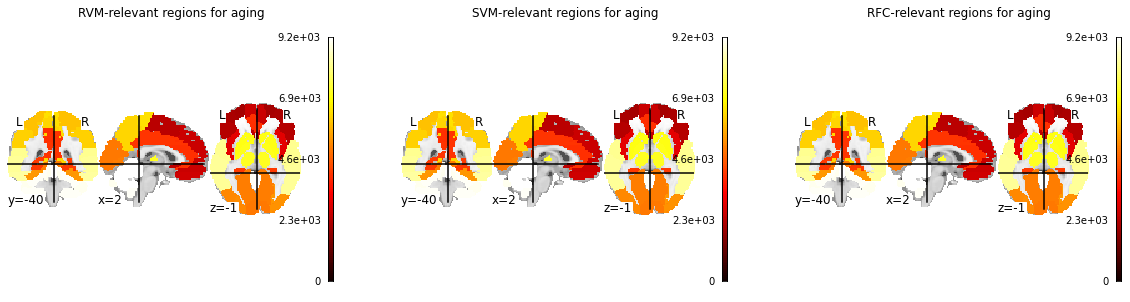

In [137]:
fix, ax = plt.subplots(1,3, figsize=(20,5))
plotting.plot_stat_map(atlas_rvm, axes = ax[0])
ax[0].set_title("RVM-relevant regions for aging")
plotting.plot_stat_map(atlas_svm, axes = ax[1])
ax[1].set_title("SVM-relevant regions for aging")
plotting.plot_stat_map(atlas_rfc, axes = ax[2])
ax[2].set_title("RFC-relevant regions for aging")
plt.show()